# CONTENTS:

## 1. Importing libraries

## 2. Importing 'Unemployment Rate in New York' data set

### 2.1. Initial data overview and plotting - Unemployment Rate in New York

### 2.2. Subsetting, wrangling, and cleaning time-series data

### 2.3. Time-series analysis: decomposition

### 2.4. Testing for stationarity

### 2.5. Stationarizing the Federal Reserve Economic Data

## 3. Importing 'Core_Metrics_Clean_Renamed_0missing.csv' data set

### 3.1. Subsetting and plotting 'core_met_sub'

### 3.2. Time-series analysis: decomposition

### 3.3. Testing for stationarity

### 3.4. Stationarizing the Federal Reserve Economic Data

____________________________________________

## 1. Importing libraries

In [57]:
# Importing libraries:

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from datetime import datetime
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

## 2. Importing 'Unemployment Rate in New York' data set

In [2]:
# Configuring API key:

quandl.ApiConfig.api_key = 'YA8Nxy6dQyP-VNbzcyid'

In [3]:
# Importing the Federal Reserve Economic Data 'Unemployment Rate in New York' (seasonally NOT adjusted):

data = quandl.get('FRED/NYURN')

data.tail()

,Value
Date,
2021-11-01,4.9
2021-12-01,4.5
2022-01-01,5.3
2022-02-01,5.1
2022-03-01,4.7


### 2.1. Initial data overview and plotting - Unemployment Rate in New York

In [4]:
# Data shape:

data.shape

(555, 1)

In [5]:
# Data Columns

data.columns

Index(['Value'], dtype='object')

In [6]:
# Data type:

type(data)

pandas.core.frame.DataFrame

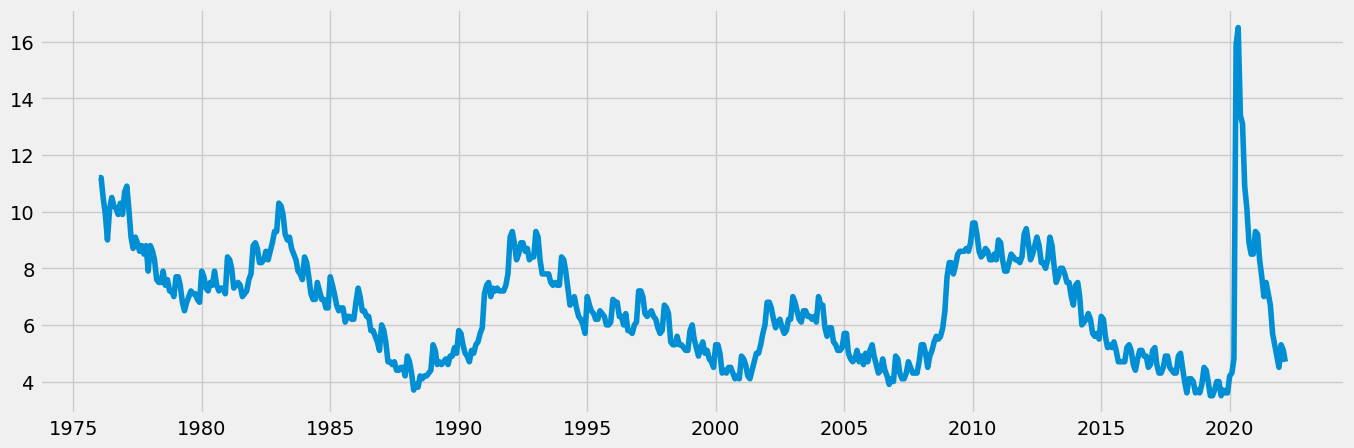

In [7]:
# Plotting the data:

plt.figure(figsize = (15, 5), dpi = 100)

plt.plot(data)

### 2.2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Resetting index to use 'Date' column as a filter:

data_2 = data.reset_index()

data_2.head()

,Date,Value
0,1976-01-01,11.2
1,1976-02-01,11.2
2,1976-03-01,10.5
3,1976-04-01,9.9
4,1976-05-01,9.0


In [11]:
# Creating a subset to include only applicable time range:

data_sub = data_2.loc[data_2['Date'] >= '2016-06-01']

data_sub.shape

(70, 2)

In [12]:
data_sub.head()

,Date,Value
485,2016-06-01,4.8
486,2016-07-01,5.1
487,2016-08-01,5.1
488,2016-09-01,4.9
489,2016-10-01,4.9


#### Comments:

All the data dated before 2016-06-01 were removed from the subset to match the time range in the 'Core_Metrics_Clean_Renamed_0missing.csv'.

_____________________________

In [13]:
# Setting the 'Date' column back as an index:

    # ... using 'from datetime import datetime'
    
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Creating a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Setting the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis = 1, inplace = True) # Dropping the "Date" column.
data_sub.head()

,Value
datetime,
2016-06-01,4.8
2016-07-01,5.1
2016-08-01,5.1
2016-09-01,4.9
2016-10-01,4.9


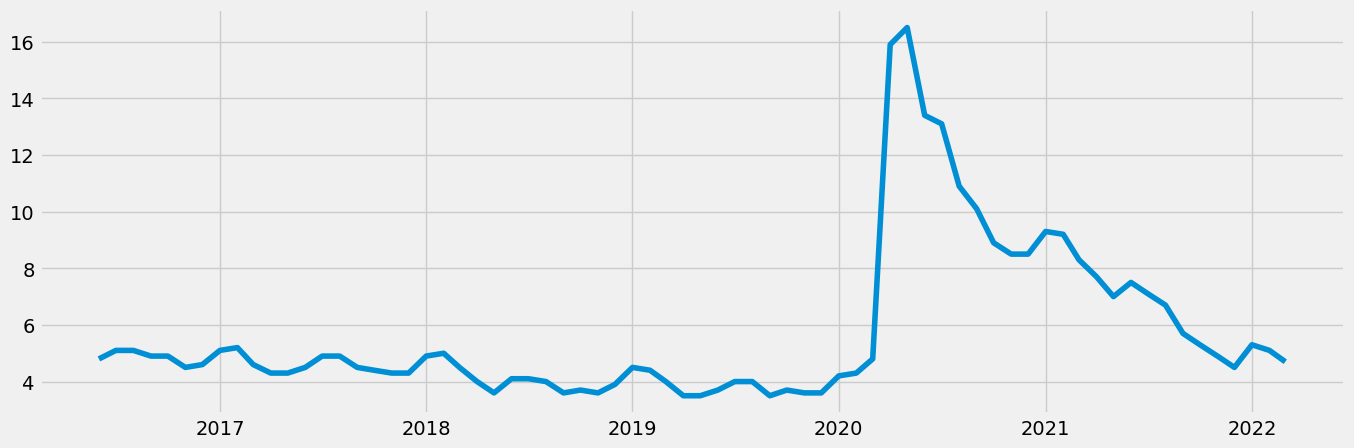

In [14]:
# Plotting the subset:

plt.figure(figsize = (15, 5), dpi = 100)
plt.plot(data_sub)

In [15]:
# Checking for missing values:

data_sub.isnull().sum() # No missing calues detected.

Value    0
dtype: int64

In [16]:
# Checking for duplicates in data_2 (the original data set with 'Date' as non-index):

dups = data_2.duplicated()

dups.sum() # No duplicates detected.

0

### 2.3. Time-series analysis: decomposition

In [17]:
# Decomposing the time series using as additive model:

decomposition = sm.tsa.seasonal_decompose(data_sub, model = 'additive')

In [18]:
# Defining a fixed size for all special charts:

    # ... using 'from pylab import rcParams'.
    
rcParams['figure.figsize'] = 18, 7

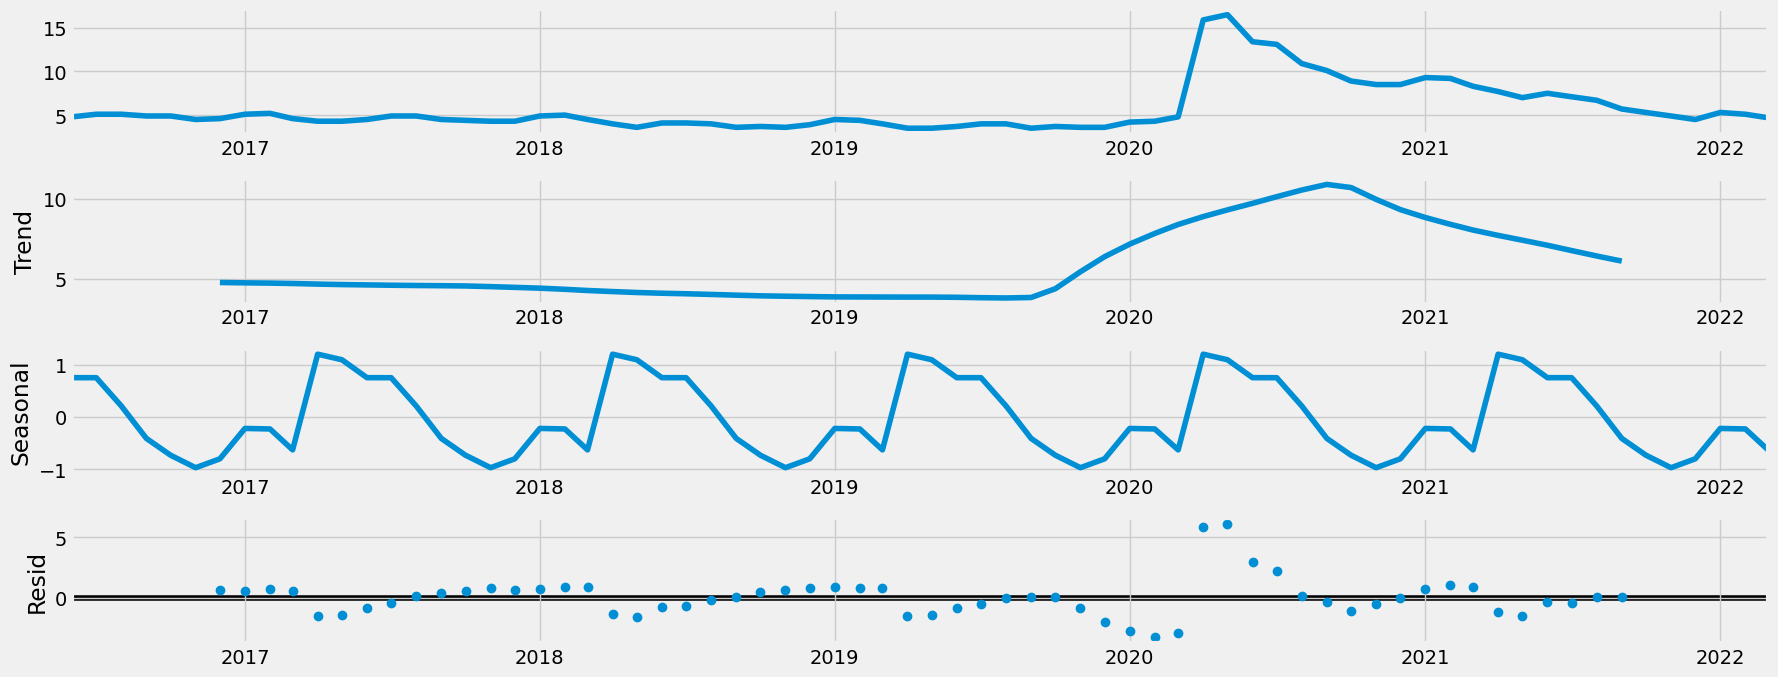

In [19]:
# Plotting the separate components:

decomposition.plot()

plt.show()

### 2.4. Testing for stationarity

In [20]:
# Importing the addfuller() function:

from statsmodels.tsa.stattools import adfuller

In [38]:
# Defining a fuction around the Dickey-Fuller test:

def dickey_fuller(timeseries):
    
    print('Dickey-Fuller Stationarity Test:')
    test = adfuller(timeseries, autolag = 'AIC')
    result = pd.Series(test[0:4], index = ['Test statistic', 'p-value', 
                                           'Numver of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical value (%s)'%key] = value
    return result

In [39]:
# Applying the test using the fuction on time series:

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity Test:


Test statistic                 -2.544891
p-value                         0.104930
Numver of Lags Used             1.000000
Number of Observations Used    68.000000
Critical value (1%)            -3.530399
Critical value (5%)            -2.905087
Critical value (10%)           -2.590001
dtype: float64

#### Comments:

The test statistic of -2.52 (5%) is larger than critical value of -2.90, which means that the null hypothesis cannot be rejected - so the is a unit root in the data - so the data is not stationary and require additional manipulations before any predictions can be made.

_______________________________

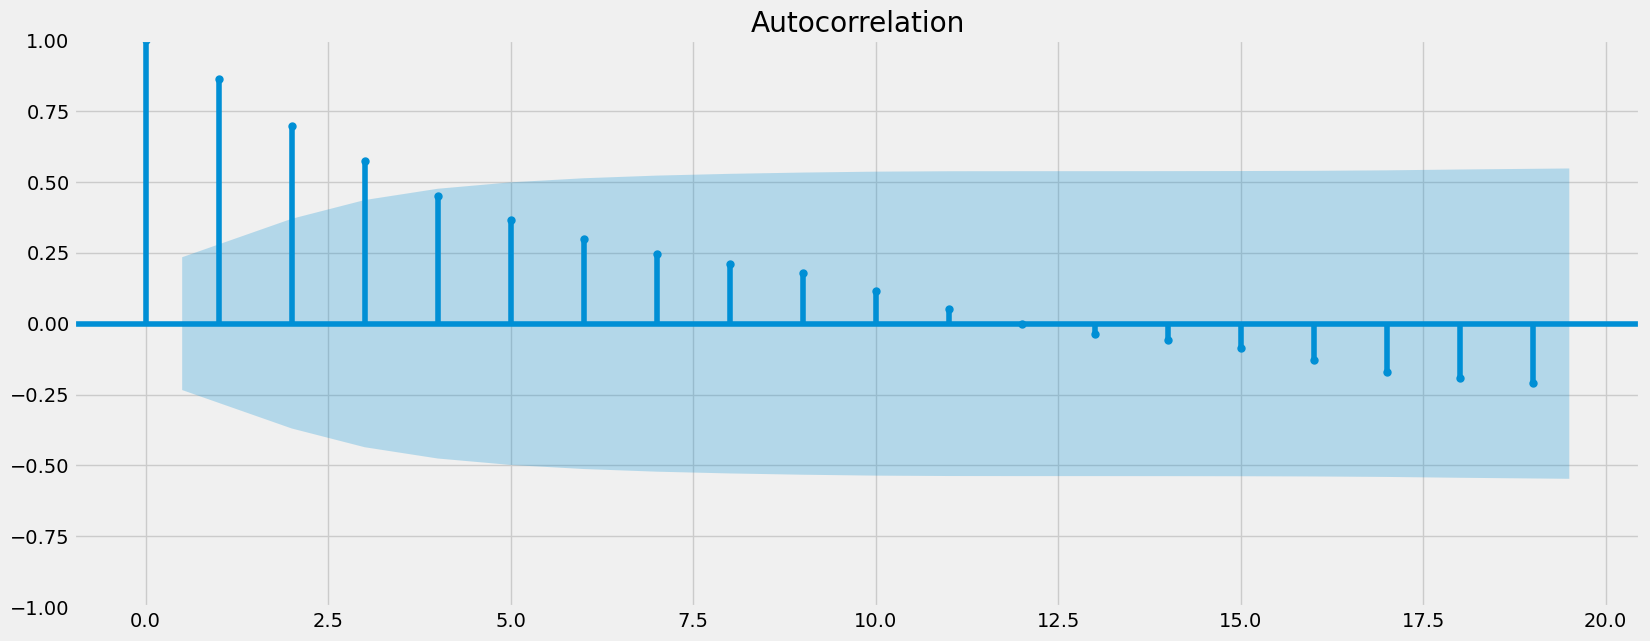

In [23]:
# Checking for autocorrelations:

    # ... using 'from statsmodels.graphics.tsaplots import plot_acf, plot_pacf'.
    
plot_acf(data_sub)
plt.show()

#### Comments:

There are a few lags in the series that are beyond the blue area of the confidence interval, meaning that those lags are significantly correlated with each other. This means that the data set is non-stationary.

___________________________________

### 2.5. Stationarizing the Federal Reserve Economic Data

In [24]:
# Turning the observation to t-1 (making the while thing t-(t-1)) with the help of df.shift(1):

data_diff = data_sub - data_sub.shift(1)

In [25]:
# Removing the missing values that appeared as a result of the differencing:

data_diff.dropna(inplace = True)

In [26]:
data_diff.head()

,Value
datetime,
2016-07-01,0.3
2016-08-01,0.0
2016-09-01,-0.2
2016-10-01,0.0
2016-11-01,-0.4


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

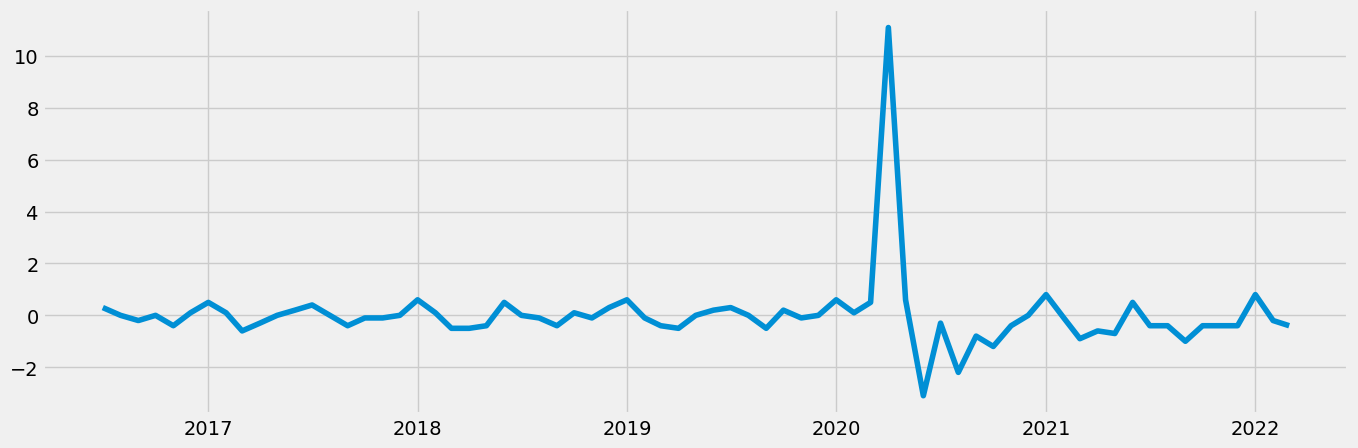

In [29]:
# Looking at the result of the differencing on the time-series curve:

plt.figure(figsize = (15, 5), dpi = 100)
plt.plot(data_diff)

In [56]:
# Re-running Dickey-Fuller on 'data_diff':

dickey_fuller(data_diff).apply(lambda s: '{0:.5f}'.format(s))

Dickey-Fuller Stationarity Test:


Test statistic                 -7.23062
p-value                         0.00000
Numver of Lags Used             0.00000
Number of Observations Used    68.00000
Critical value (1%)            -3.53040
Critical value (5%)            -2.90509
Critical value (10%)           -2.59000
dtype: object

#### Comments:

After differencing has been applied the test statistic of -7.23 became much smaller than any of the critical values, making the time-series stationary. The p-value is at 0, meaning that we can safely reject the null hypothesis, which additionally confirms that the series is stationary.

__________________________________

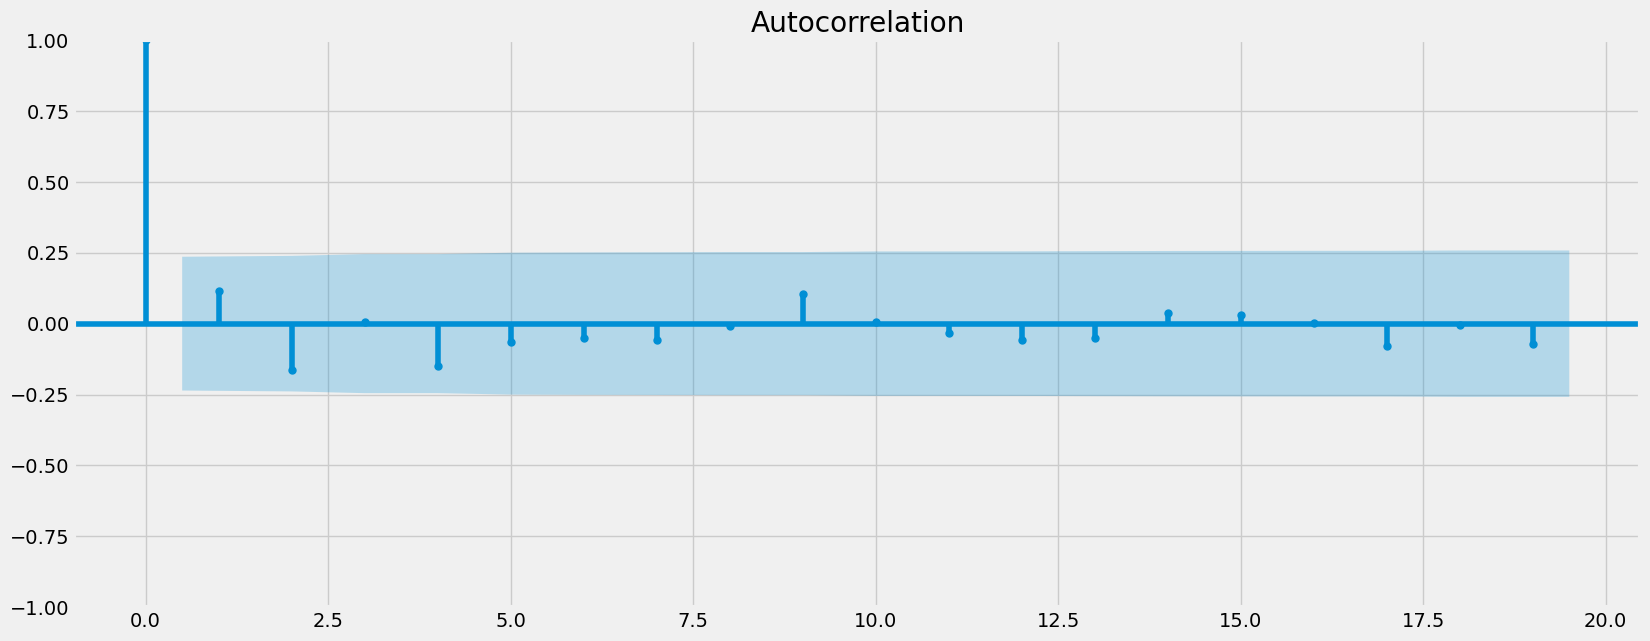

In [34]:
# Plotting the autocorrelations:

plot_acf(data_diff)
plt.show()

#### Comments:

There is only one lag that sticks beyond the confidence interval, meaning that stationarity is rather strong.

_________________________

## 3. Importing 'Core_Metrics_Clean_Renamed_0missing.csv' data set

In [58]:
# Importing 'Core_Metrics_Clean_Renamed_0missing.csv' as 'core_met':

path = r'/Users/elena/Documents/Data Analytics Course/6. Advanced Analytics and Dashboard Design'

core_met = pd.read_csv(os.path.join(path, 'Core_Metrics_Clean_Renamed_0missing.csv'))

### 3.1. Subsetting and plotting 'core_met_sub'

In [146]:
# Subsetting the 'core_met' to include only 'Date' and 'Median Sq Ft Price':

core_met_sub = core_met.groupby('Date').agg({'Median Sq Ft Price': "mean"})
core_met_sub.head()

,Median Sq Ft Price
Date,
201607,143.019608
201608,142.058824
201609,142.000000
201610,142.156863
201611,141.901961


In [147]:
# Changing data type in the 'Date' column:

from datetime import datetime

core_met_sub = core_met_sub.reset_index() # Reintroducing the index to make 'Date' a regular column to change its type.
core_met_sub['Date'] = core_met_sub['Date'].astype(str) # Setting the data type as a string.
core_met_sub['Date'] = pd.to_datetime(core_met_sub['Date'], format = '%Y%m') # Changing the data type to string to date.
core_met_sub = core_met_sub.set_index('Date') # Setting 'Date' column back as index.

core_met_sub.head()

,Median Sq Ft Price
Date,
2016-07-01,143.019608
2016-08-01,142.058824
2016-09-01,142.000000
2016-10-01,142.156863
2016-11-01,141.901961


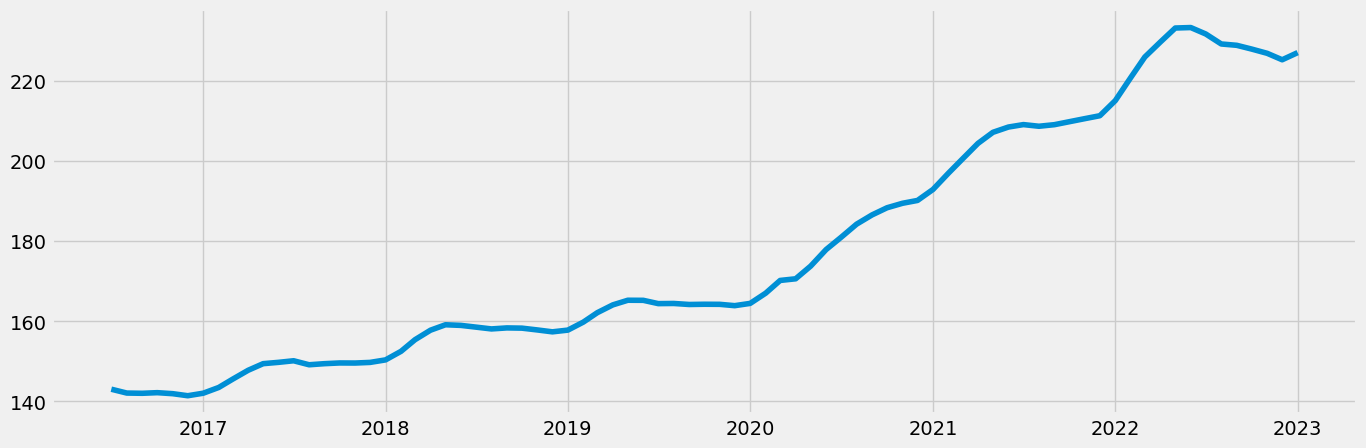

In [144]:
plt.figure(figsize = (15, 5), dpi = 100)
plt.plot(core_met_sub)

### 3.2. Time-series analysis: decomposition

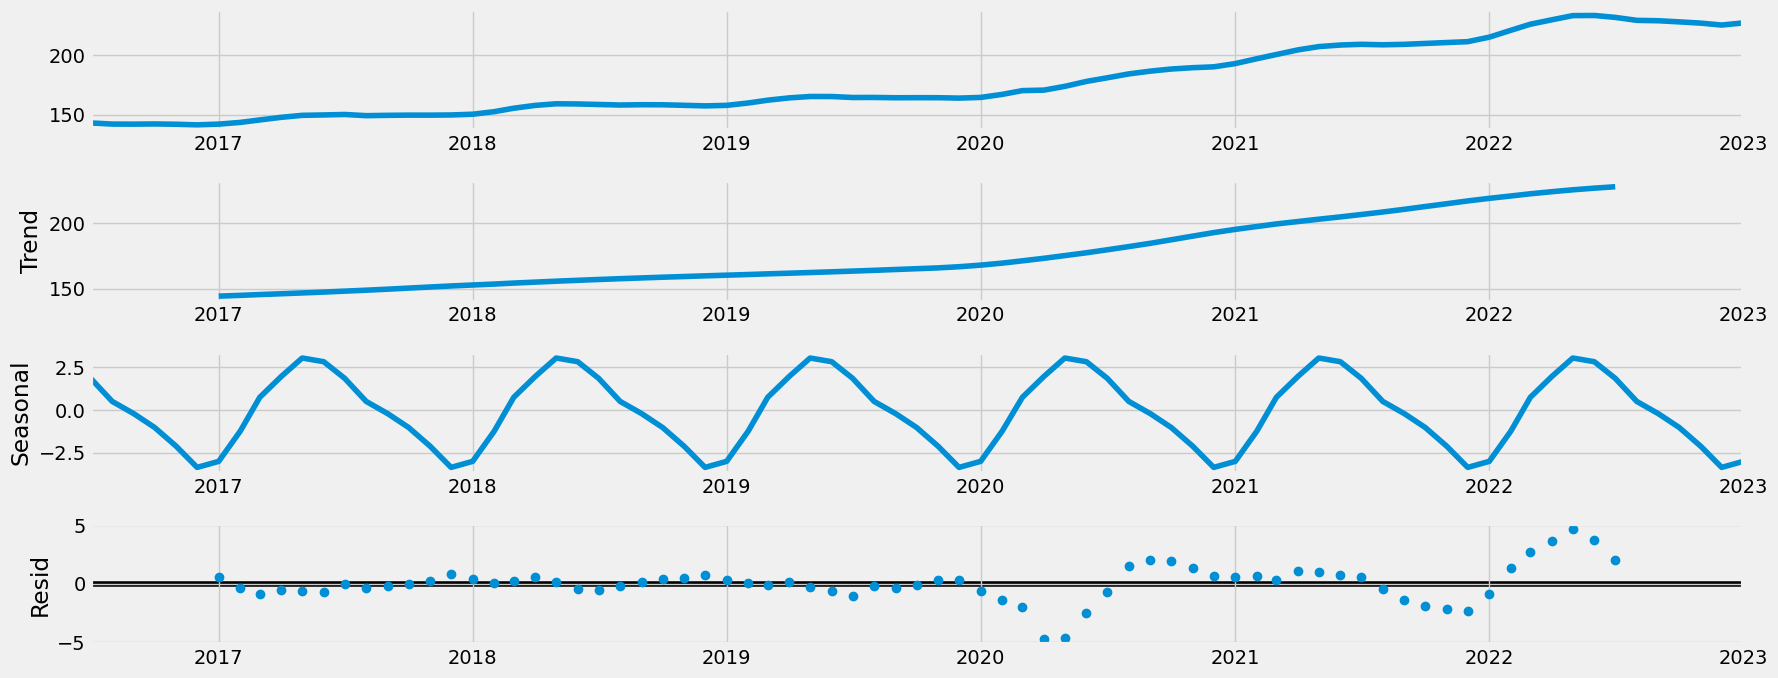

In [149]:
# Plotting the separate components:

decomposition = sm.tsa.seasonal_decompose(core_met_sub, model = 'additive')
decomposition.plot() # Plotting the components.
plt.show()

### 3.3. Testing for stationarity

In [160]:
# Performing Dickey-Fuller Stationarity Test (from statsmodels.tsa.stattools import adfuller):

def dickey_fuller(timeseries):
    print('Dickey_Fuller Stationarity test:')
    test = adfuller(timeseries, autolag = 'AIC')
    result = pd.Series(test[0:4], index = ['Test statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items(): 
        result['Ctitical value (%s)'%key] = value
    print(result)

dickey_fuller(core_met_sub['Median Sq Ft Price'])

Dickey_Fuller Stationarity test:
Test statistic                 -0.846350
p-value                         0.805127
Number of Lags Used            11.000000
Number of Observations Used    67.000000
Ctitical value (1%)            -3.531955
Ctitical value (5%)            -2.905755
Ctitical value (10%)           -2.590357
dtype: float64


#### Comments:

The test statistic of -0.84 is much larger than any of the critical vlaues, which means that the data is not stationary.

_____________________________

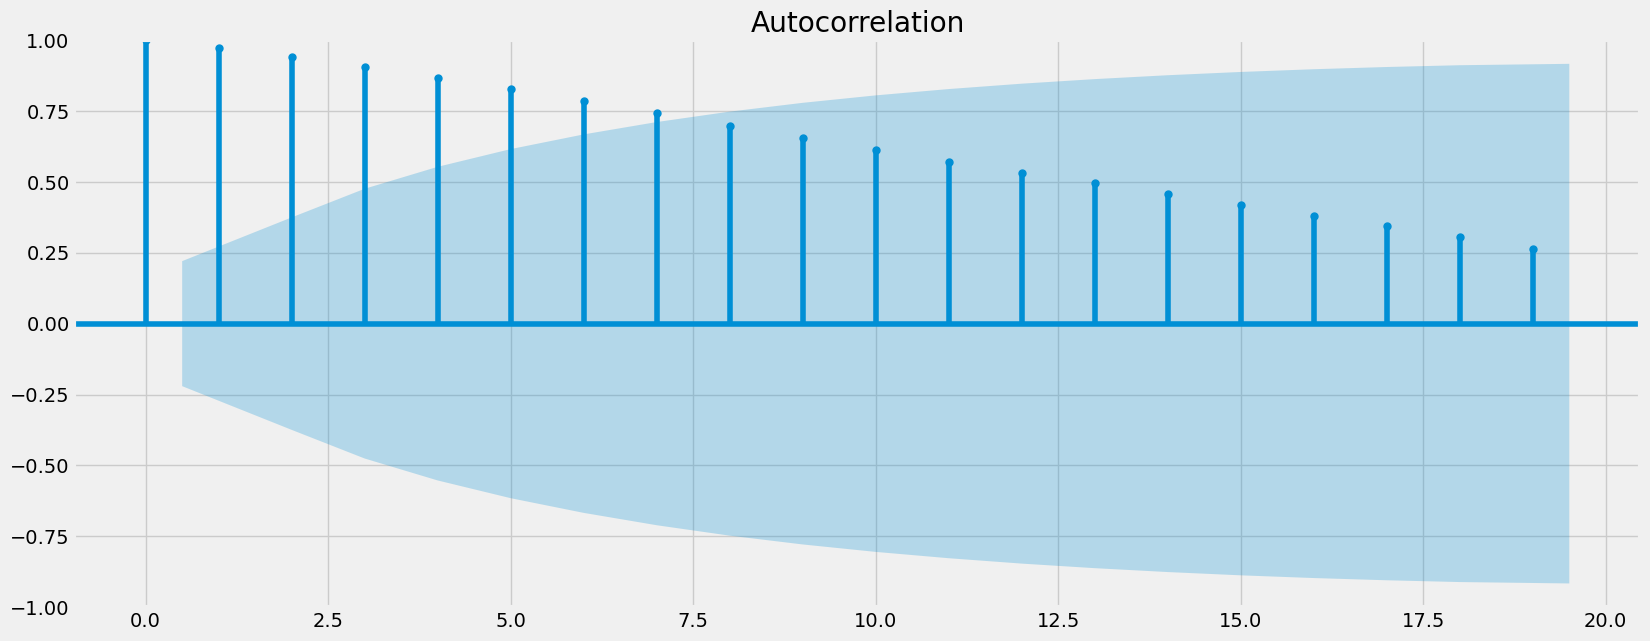

In [161]:
# Ckecking for autocorrections (from statsmodels.graphics.tsaplots import plot_acf, plot_pacf):

plot_acf(core_met_sub)
plt.show()

#### Comments:

There are quie a few lags that go beyond the area of confidence, meaning that the data is not stationary.

_______________________________

### 3.4. Stationarizing the Federal Reserve Economic Data

In [163]:
# Differencing - turning the observation to t-1 (making the while thing t-(t-1)) with the help of df.shift(1):

core_met_diff = core_met_sub - core_met_sub.shift(1)

In [166]:
# Removing the missing values that appeared as a result of the differencing:

core_met_diff.dropna(inplace = True)
core_met_diff.head()

,Median Sq Ft Price
Date,
2016-08-01,-0.960784
2016-09-01,-0.058824
2016-10-01,0.156863
2016-11-01,-0.254902
2016-12-01,-0.509804


In [167]:
core_met_diff.columns

Index(['Median Sq Ft Price'], dtype='object')

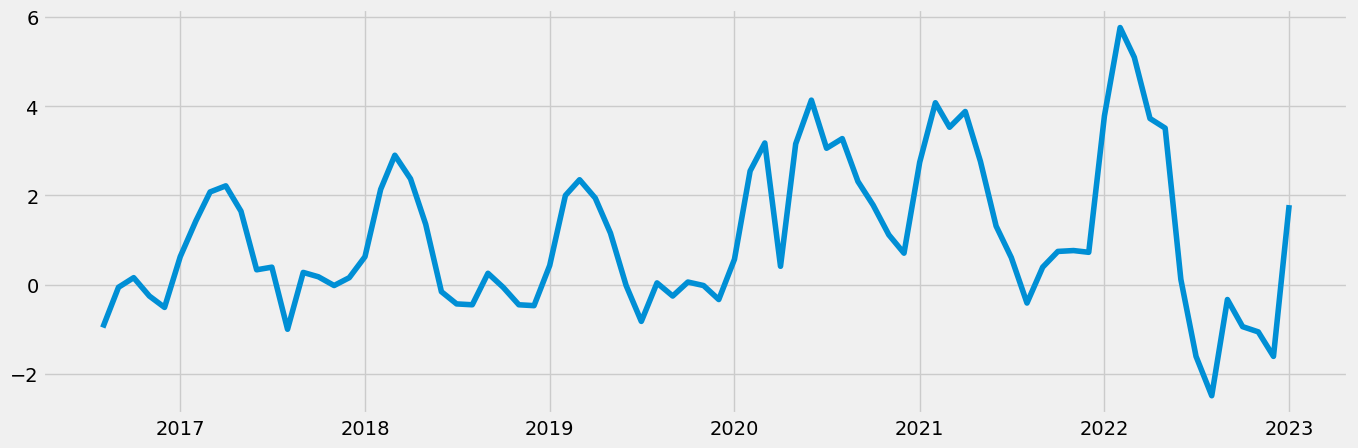

In [168]:
# Checking out what the differencing did to the time-series curve:

plt.figure(figsize=(15,5), dpi=100)
plt.plot(core_met_diff)

In [169]:
# Rerunning Dickey-Fuller on the differenced data:

dickey_fuller(core_met_diff)

Dickey_Fuller Stationarity test:
Test statistic                 -1.641586
p-value                         0.461432
Number of Lags Used            12.000000
Number of Observations Used    65.000000
Ctitical value (1%)            -3.535217
Ctitical value (5%)            -2.907154
Ctitical value (10%)           -2.591103
dtype: float64


#### Comments:

The Test statistic is still of -1.64 is still larger than any Critical value, which is asking for an additional run of differencing. The p-value is quite high: 0.46, which means we still cannot reject the null hypothsis.

__________________________________

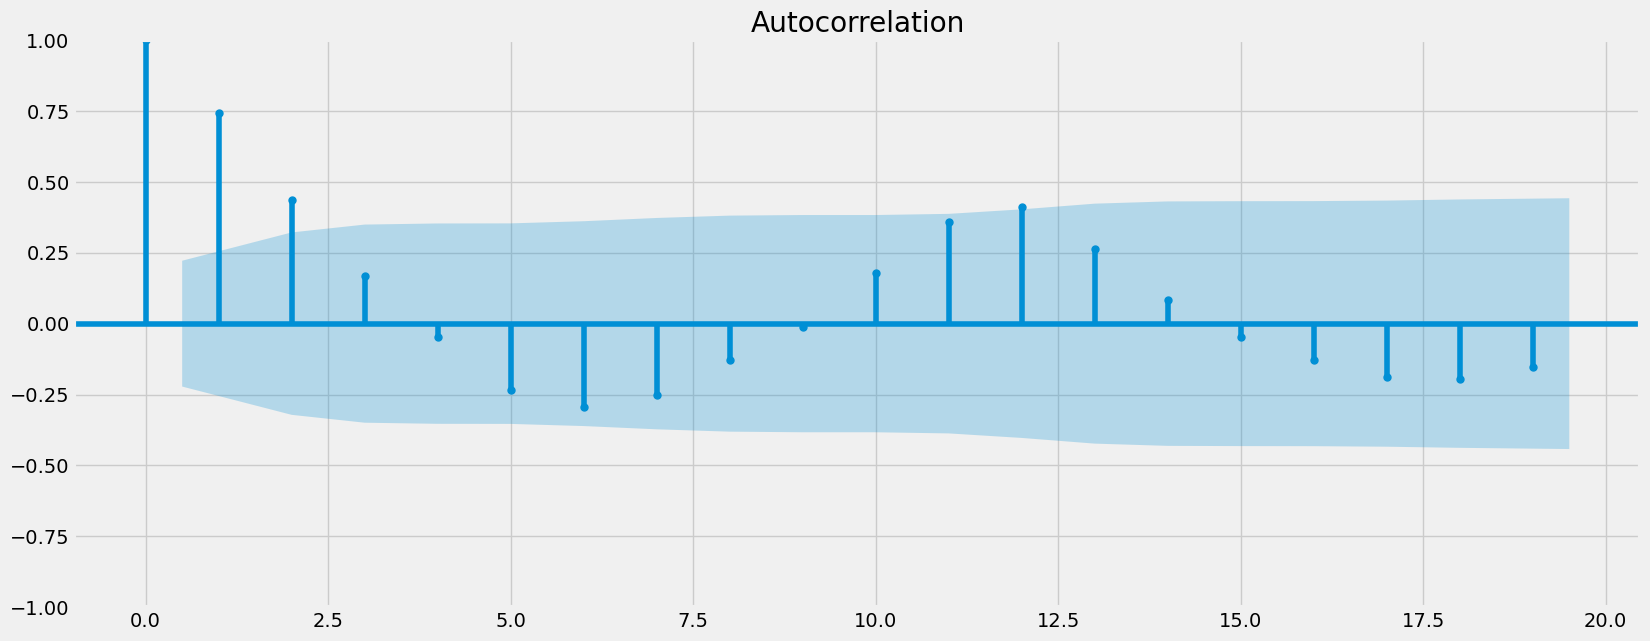

In [170]:
# Rechecking for autocorrelations:

plot_acf(core_met_diff)
plt.show()

#### Comments:

There are 4 lags that stick beyond the area of confidence. That is not al lot but in conjunction with the Dickey_Fuller Stationarity test results, tell us that the non-stationarity of the data has not been yet resolved.

_______________________________

In [171]:
# 2nd Differencing:

core_met_diff_2 = core_met_diff - core_met_diff.shift(1)

In [172]:
# Removing the missing values after differencing 2:

core_met_diff_2.dropna(inplace = True)
core_met_diff_2.head()

,Median Sq Ft Price
Date,
2016-09-01,0.901961
2016-10-01,0.215686
2016-11-01,-0.411765
2016-12-01,-0.254902
2017-01-01,1.137255


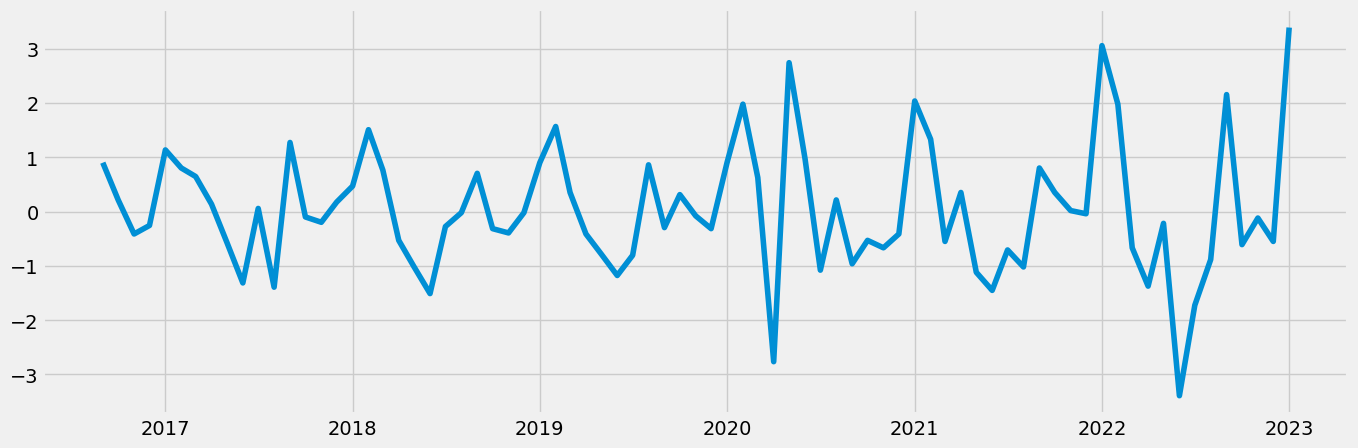

In [173]:
# Plotting after the 2nd differencing:

plt.figure(figsize=(15,5), dpi=100)
plt.plot(core_met_diff_2)

In [174]:
# Rerunning Dickey-Fuller after the 2nd differencing:

dickey_fuller(core_met_diff_2)

Dickey_Fuller Stationarity test:
Test statistic                 -2.517695
p-value                         0.111228
Number of Lags Used            11.000000
Number of Observations Used    65.000000
Ctitical value (1%)            -3.535217
Ctitical value (5%)            -2.907154
Ctitical value (10%)           -2.591103
dtype: float64


#### Comments:

This time aroung the Test statistic -2.51 is still larger that any of the Critical values. 

___________________________

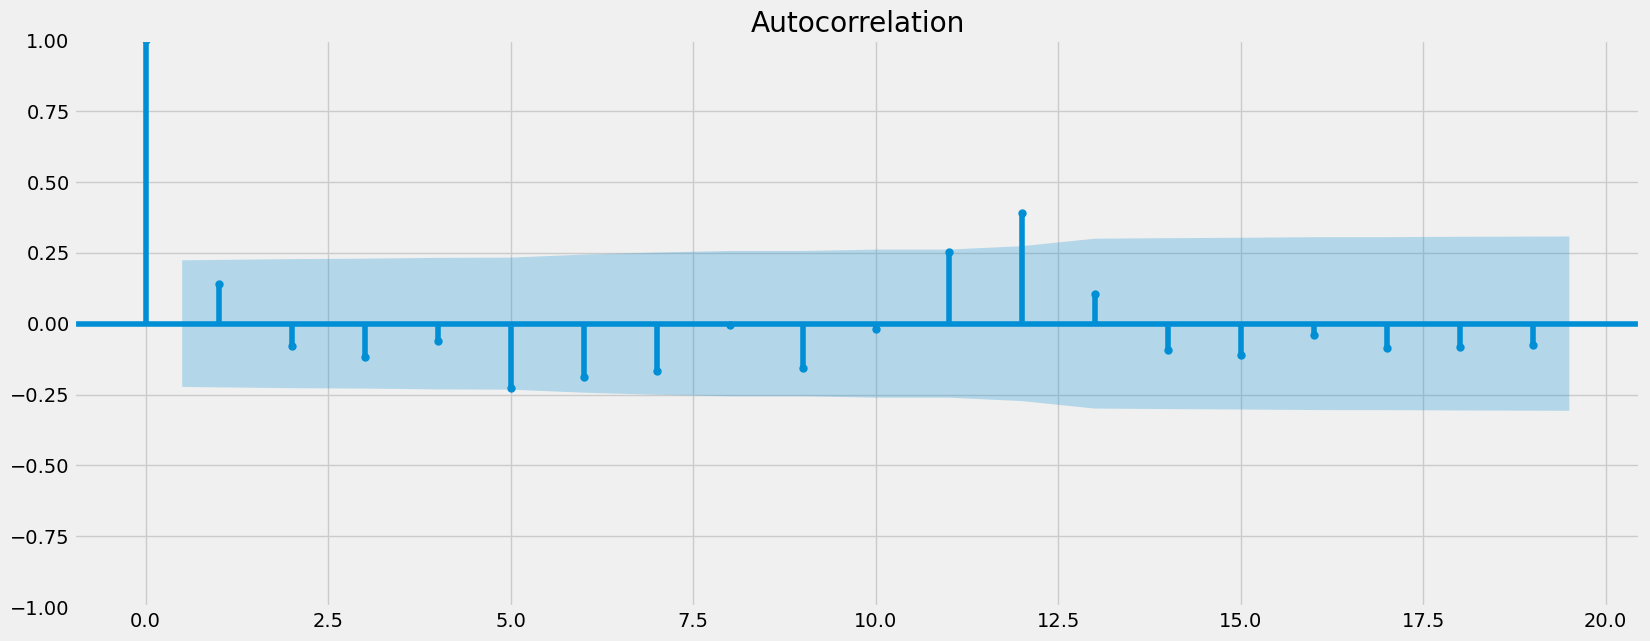

In [175]:
# Rechecking for autocorrelations after the 2nd differencing:

plot_acf(core_met_diff_2)
plt.show()

#### Comments:

This time around there are only two lags that go beyond the area of confidence.

_________________________________